In [1]:
import numpy as np          
from matplotlib import pyplot as plt

In [14]:
s0 = np.random.normal(100,1,200)
s1 = [50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,400,500,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 

def readFromRecord(path):
    with open(path, 'r') as f:
        data = f.read()
        if len(data) == 0: 
            return []
        data = data.split(',')
        data = [int(string) for string in data]
        return data

In [232]:
#一阶滞后滤波法
import stats as sts
def Hysteresis(s, a):
    list_s = [s[0]]
    for i in range(len(s)-1): 
        s[i+1] = (1-a) * s[i+1] + a * s[i]
        list_s.append(s[i+1])
    return list_s

def Hysteresis2(s, a, n, bMean=True):
    result = []
    res_idx = []
    C_list = []
    sk = []
    std_list = []
    for i in range(int(len(s)/n)):
        last_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        cur_s = s[(i+1)*n:(i+2)*n] 
        if len(cur_s) == 0:
            break
        # select_s = sorted(select_s)   # 去除最大和最小的
        # select_s.remove(select_s[0])
        # select_s.remove(select_s[-1])
        mean_s = np.mean(cur_s)   # median
        if bMean:
            res = (1-a)*np.mean(cur_s) + a*np.mean(last_s)  # a越小,当前值占比更大
        else:
            res = (1-a)*np.median(cur_s) + a*np.median(last_s)
        result.append(res)
        res_idx.append((i+1)*n)

        C = np.std(cur_s)/(mean_s + 1)
        C_list.append(C)
        std_list.append(np.std(cur_s))
        if len(cur_s) >= 2:
            sk.append(sts.skewness(cur_s))  # *200 + 200

    return result, res_idx, C_list, sk, std_list

def Hysteresis3(s, a, n, bMean=True, byMinMax = True, p=10, q=2, log=False):
    result = []
    res_idx = []
    last_min = 9999999
    last_max = -1
    P = p
    Q = q
    std_list = []
    minmax_list = [[], [], [], []]
    for i in range(int(len(s)/n)):
        last_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        cur_s = s[(i+1)*n:(i+2)*n] 
        if byMinMax:
            start = max(0, (i+1)*n-P)
            find_max_min = s[start:(i+1)*n]
        else:
            # start = max(0, (i+1)*n-P)
            find_max_min = []
            if len(std_list) >= Q:
                find_max_min = std_list[-Q:]

        if len(cur_s) == 0:
            break

        mean_s = np.mean(cur_s)   # median
        std_s = np.std(cur_s)
        if log:
            if byMinMax:
                print("min=",last_min, "cur=",mean_s, "max=",last_max)
            else:
                print("min=",last_min, "cur=",std_s, "max=",last_max)

        if bMean:
            res = (1-a)*np.mean(cur_s) + a*np.mean(last_s)  # a越小,当前值占比更大
        else:
            res = (1-a)*np.median(cur_s) + a*np.median(last_s)

        if byMinMax:
            if res <= last_max and res >= last_min and len(result) != 0:
                res = result[-1]
            else:
                if len(find_max_min) != 0:    #超出，更新最大最小范围
                    last_max = max(find_max_min)
                    last_min = min(find_max_min)
        else:
            if std_s <= last_max and std_s >= last_min and len(result) != 0:
                res = result[-1]
            else:
                if len(find_max_min) != 0:    #超出，更新最大最小范围
                    last_max = max(find_max_min)
                    last_min = min(find_max_min)
                    delta = last_max - last_min
                    delta = max(0.1, delta*1.2)
                    last_max += delta
                    last_min = max(0, last_min-delta)


        if last_min != -1:
            minmax_list[0].append(last_min)
            minmax_list[1].append(std_s)
            minmax_list[2].append(last_max)
            minmax_list[3].append((i+1)*n)
        result.append(res)
        res_idx.append((i+1)*n)
        std_list.append(std_s)

    return result, res_idx, minmax_list


def Hysteresis4(s, a, n, bMean=True):
    result = []
    res_idx = []
    C_list = []
    sk = []
    for i in range(int(len(s)/n)):
        select_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        next_s = s[(i+1)*n:(i+2)*n] 
        if len(next_s) == 0:
            break
        mean_s = np.mean(select_s)   # median
        if bMean:
            res = (1-a)*np.mean(next_s) + a*np.mean(select_s)
        else:
            res = (1-a)*np.median(next_s) + a*np.median(select_s)

        C = np.std(select_s)/(mean_s + 1)
        C_list.append(C)
        sk.append(sts.skewness(select_s) )  # *200 + 200

        if len(sk) != 0 and C < 0.05 and len(result) != 0:
            res = result[-1]

        result.append(res)
        res_idx.append((i+1)*n)

    return result, res_idx

def Hysteresis5(s, a, n, bMean=True):
    result = []
    res_idx = []
    C_list = []
    sk = []
    N = 10
    for i in range(int(len(s)/n)):
        select_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        next_s = s[(i+1)*n:(i+2)*n] 
        if len(next_s) == 0:
            break
        start = max(0, i*n-N)
        CCC = s[start:i*n]
        C_large = 0
        if len(CCC) != 0:
            C_large = np.std(CCC)/(np.mean(CCC) + 1)
        mean_s = np.mean(select_s)   # median
        if bMean:
            res = (1-a)*np.mean(next_s) + a*np.mean(select_s)
        else:
            res = (1-a)*np.median(next_s) + a*np.median(select_s)

        C = np.std(select_s)/(mean_s + 1)
        C_list.append(C)
        sk.append(sts.skewness(select_s) )  # *200 + 200

        if C_large < 0.1 and len(result) != 0:
            res = result[-1]

        result.append(res)
        res_idx.append((i+1)*n)

    return result, res_idx

In [206]:
def Hysteresis6(s, a, n, bMean=True):   # 4-8-16
    result = []
    res_idx = []
    C_list = []
    sk = []
    std_list = []
    std_last = -1
    th_min = 4
    th_max = 16
    i = 0
    n_list = []
    while i < len(s):
        cur_s = s[i:i+n]
        i = i + n
        # print('len(cur_s)', len(cur_s), 'i=', i)

        n_list.append(n)

        cur_mean = np.mean(cur_s)
        cur_std = np.std(cur_s)
        if bMean:
            cur_s = np.mean(cur_s)
        else:
            cur_s = np.median(cur_s)

        last_s = cur_s
        result.append(cur_s)
        res_idx.append(i)
        std_list.append(cur_std)
        if std_last == -1:
            std_last = cur_std
            continue
        else:
            if cur_std > std_last:  # 波动增大
                n = max(th_min, n-(n-th_min)//2)
                # n = th_min
            else:
                n = min(th_max, n+2)
            std_last = cur_std
        
        res = (1-a)*cur_s + a*last_s  # a越小,当前值占比更大

        result.append(res)
        res_idx.append(i)
        last_s = res
        C = cur_std/(cur_mean + 1)
        C_list.append(C)
        
        if len(s[i:i+n]) >= 2:
            sk.append(sts.skewness(s[i:i+n]))  # *200 + 200
    print("n:", n_list)
    return result, res_idx, C_list, sk, std_list

In [186]:
def Hysteresis3_2(s, a, n, bMean=True, byMinMax = True, p=10, q=2, log=False):
    result = []
    res_idx = []
    last_min = 9999999
    last_max = -1
    P = p
    Q = q
    std_list = []
    minmax_list = [[], [], [], []]
    for i in range(int(len(s)/n)):
        last_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        cur_s = s[(i+1)*n:(i+2)*n] 
        if last_max == -1:
            if byMinMax and (i+1)*n > P :
                start = max(0, (i+1)*n-P)
                find_max_min = s[start:(i+1)*n]
            else:
                # start = max(0, (i+1)*n-P)
                find_max_min = []
                if len(std_list) >= Q:
                    find_max_min = std_list[-Q:]

        if len(cur_s) == 0:
            break

        mean_s = np.mean(cur_s)   # median
        std_s = np.std(cur_s)
        if log:
            if byMinMax:
                print("min=",last_min, "cur=",mean_s, "max=",last_max)
            else:
                print("min=",last_min, "cur=",std_s, "max=",last_max)

        if bMean:
            res = (1-a)*np.mean(cur_s) + a*np.mean(last_s)  # a越小,当前值占比更大
        else:
            res = (1-a)*np.median(cur_s) + a*np.median(last_s)

        res_idx.append((i+1)*n)
        std_list.append(std_s)
        if len(result) == 0:
            result.append(res)
            continue

        if byMinMax:
            if res <= last_max and res >= last_min and len(result) != 0:
                res = result[-1]
            else: #超出，更新最大最小范围
                find_max_min = s[(i+2)*n-P:(i+2)*n]
                if len(find_max_min) > 0:
                    last_max = max(find_max_min)
                    last_min = min(find_max_min)
        else:
            if std_s <= last_max and std_s >= last_min and len(result) != 0:
                res = result[-1]
            else: #超出，更新最大最小范围
                find_max_min = std_list[-Q:]    
                last_max = max(find_max_min)
                last_min = min(find_max_min)

        if last_min != -1:
            minmax_list[0].append(last_min)
            minmax_list[1].append(std_s)
            minmax_list[2].append(last_max)
            minmax_list[3].append((i+1)*n)
        result.append(res)
        

    return result, res_idx, minmax_list

C:\codes\python\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\codes\python\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\codes\python\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\codes\python\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\codes\python\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


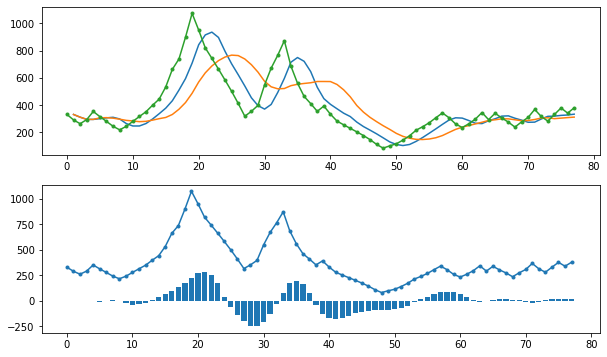

In [236]:
def MA(s, n):
    mean = []
    std = []
    for i in range(len(s)):    # 连续
        start = max(0, i-n)
        data = s[start:i]
        mean_s = np.mean(data)
        std_s = np.std(data)
        mean.append(mean_s)
        std.append(std_s)
    return mean, std

def MA_Sec(s, n):
    mean = []
    std = []
    C_list = []
    for i in range(int(len(s)/n)):   # 分段
        data = s[i*n:(i+1)*n] 
        mean_s = np.mean(data)
        std_s = np.std(data)
        mean.append(mean_s)
        std.append(std_s)
        C_list.append(std_s / (mean_s))
    return mean, std, C_list
    
s = readFromRecord('record.txt')
mean1, std = MA(s, 4)
mean2, std2 = MA(s, 10)
plt.figure(figsize = (10,6))
plt.subplot(2,1,1)
t = np.arange(0,len(mean1),1)
plt.plot(t,mean1)
plt.plot(t,mean2)
plt.plot(t,s, marker='.')

plt.subplot(2,1,2)
mean3 = []
for i in range(len(mean1)):
    mean3.append(mean1[i] - mean2[i])
# plt.plot(t,mean3)   # , marker='.'
plt.bar(t,mean3) 
plt.plot(t,s, marker='.')
plt.show()

n: [4, 4, 6, 5, 7, 6, 8, 10, 12, 8, 10, 7, 6, 8, 6]


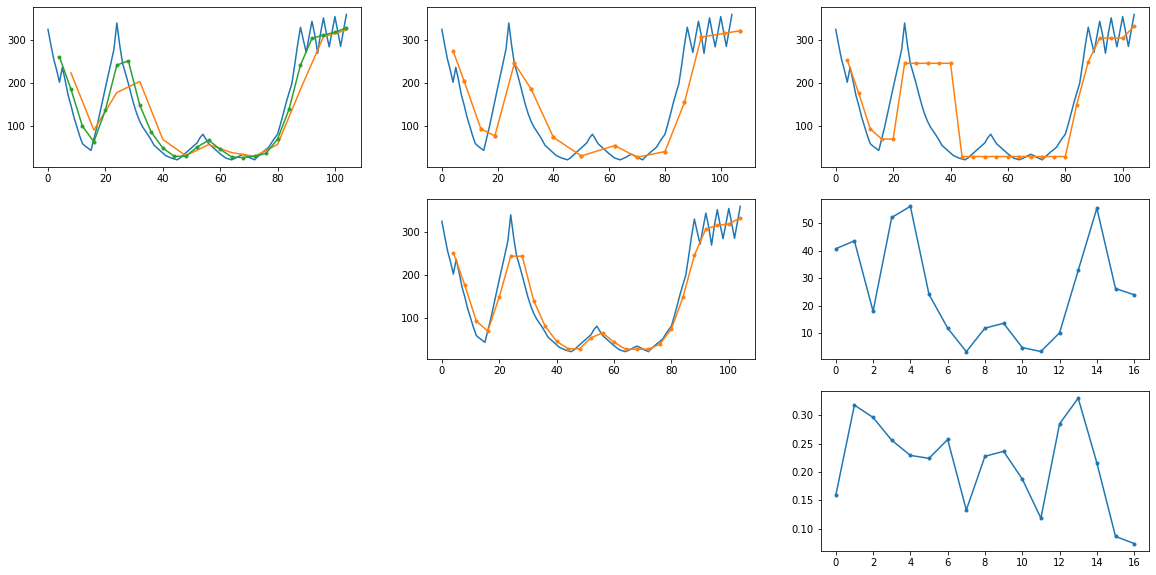

In [235]:
#一阶滞后滤波法
plt.figure(figsize = (20,10))
# plt.plot(s,label = '原始数据')
#a取0-1之间，a越接近1越稳定，越接近0越灵敏
# s = Hysteresis(s, 0.9)
s = s1
s = readFromRecord('record2.txt')

plt.subplot(3,3,1)
plt.plot(s)
# list_s = Hysteresis(s, 0.2)
# plt.subplot(3,3,2)
# plt.plot(list_s)

# list_s = Hysteresis(s, 0.4)
# plt.subplot(3,3,3)
# plt.plot(list_s)
# list_s = Hysteresis(s, 0.6)
# plt.subplot(3,3,4)
# plt.plot(list_s)

list_s1, res_idx1, C_list1, sk1, std_list = Hysteresis2(s, 0.9, 8)
plt.subplot(3,3,1)
plt.plot(res_idx1,list_s1, linestyle="-")
list_s2, res_idx, C_list, sk, std_list = Hysteresis2(s, 0.8, 4)
plt.plot(res_idx, list_s2, marker='.')

list_s2, res_idx, C_list, sk, std_list = Hysteresis6(s, 0.8, 4)
plt.subplot(3,3,2)
plt.plot(s)
plt.plot(res_idx, list_s2, marker='.')


# plt.subplot(3,3,4)
# plt.plot(res_idx, std_list, marker='+')

# plt.subplot(3,3,4)
# plt.plot(res_idx, sk, marker='x')
# plt.plot(res_idx, list_s, marker='.')

# plt.subplot(3,3,5)
# list_s2, res_idx2, C_list2, sk2 = Hysteresis2(s, 0.7, 4, False)
# plt.plot(res_idx, list_s, marker='.')
# plt.plot(res_idx, list_s2)

# 3_2前段最大最小：如果一直在0附近，变化很小，会经常变化，std应该类似
list_s3, res_idx, minmax_list = Hysteresis3(s, 0.7, 4, True, 8)
plt.subplot(3,3,3)
plt.plot(s)
plt.plot(res_idx, list_s3, marker='.')
# plt.plot(res_idx, list_s2, marker='x')
# plt.plot(minmax_list[3], minmax_list[0], linestyle="-")
# plt.plot(minmax_list[3], minmax_list[1], linestyle="-")
# plt.plot(minmax_list[3], minmax_list[2], linestyle="-")

list_s3, res_idx, minmax_list = Hysteresis3(s, 0.7, 4, False, 10, 3)
plt.subplot(3,3,5)
plt.plot(s)
plt.plot(res_idx, list_s3, marker='.')
# plt.plot(minmax_list[3], minmax_list[0], linestyle="-")
# plt.plot(minmax_list[3], minmax_list[1], linestyle="-")
# plt.plot(minmax_list[3], minmax_list[2], linestyle="-")

plt.subplot(3,3,6)
mean, std, C_list = MA_Sec(s, 6)
plt.plot(std, marker='.')
plt.subplot(3,3,9)
plt.plot(C_list, marker='.')

# list_s4, res_idx = Hysteresis5(s, 0.7, 4)
# plt.subplot(3,3,3)
# plt.plot(res_idx, list_s4, marker='.')
# plt.plot(s)
# plt.plot(res_idx, list_s2, marker='x')

plt.show()

Weights [0.25 0.25 0.25 0.25]
102 102


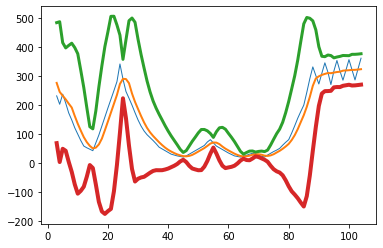

In [102]:
import numpy as np
import sys
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

N = 4

weights = np.ones(N) / N
print("Weights", weights)

# c = np.loadtxt('data.csv', delimiter=',', usecols=(6,), unpack=True)
c = readFromRecord('record2.txt')
sma = np.convolve(weights, c)[N-1:-N+1]
deviation = []
C = len(c)

for i in range(N - 1, C):
   if i + N < C:
      dev = c[i: i + N]
   else:
      dev = c[-N:]
   
   averages = np.zeros(N)
   averages.fill(sma[i - N - 1])
   dev = dev - averages 
   dev = dev ** 2
   dev = np.sqrt(np.mean(dev))
   deviation.append(dev)

deviation = 2 * np.array(deviation)
print (len(deviation), len(sma))
upperBB = sma + deviation
lowerBB = sma - deviation

c_slice = c[N-1:]
between_bands = np.where((c_slice < upperBB) & (c_slice > lowerBB))

# print (lowerBB[between_bands])
# print (c[between_bands])
# print(upperBB[between_bands])
# between_bands = len(np.ravel(between_bands))
# print ("Ratio between bands", float(between_bands)/len(c_slice))

t = np.arange(N - 1, C)
plot(t, c_slice, lw=1.0)
plot(t, sma, lw=2.0)
plot(t, upperBB, lw=3.0)
plot(t, lowerBB, lw=4.0)
show()

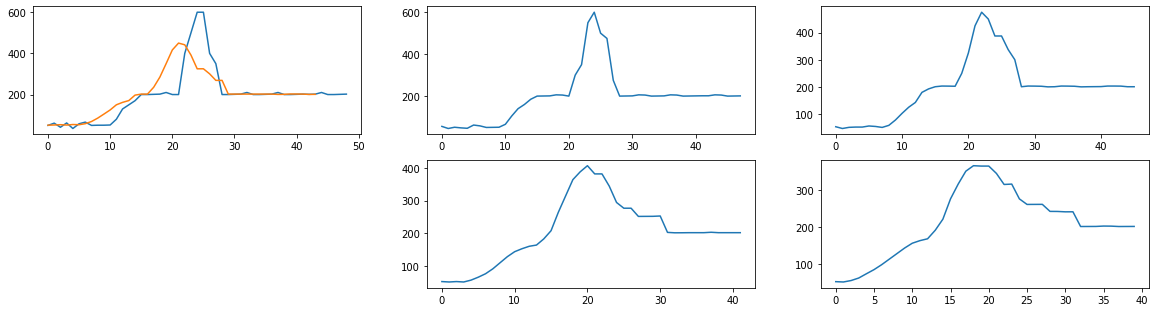

In [52]:
# 递推平均滤波法
def Recursive_average_filtering(s, que_num=4):
    N = que_num      #队列大小
    mean_list = []
    select_s = list(s[:N])      #先选择一个队列的数据，求平均
    mean = np.mean(select_s)
    select_s.insert(len(select_s),select_s[0])    #左移一位
    select_s.remove(select_s[0])
    #select_s[-1] = mean
    mean_list.append(mean)

    for i in range(len(s)-N):       #然后添加一个新数据，左移一位，去头去尾，重复迭代
        select_s.append(s[i+N])
        select_s.insert(len(select_s),select_s[0])    #左移一位
        select_s.remove(select_s[0])
        select_s.remove(select_s[-1])
        mean = np.mean(select_s)
        #select_s[-1] = mean
        mean_list.append(mean)

    return mean_list

plt.figure(figsize = (20,8))
s = s1

plt.subplot(3,3,1)
plt.plot(s)
list_s = Recursive_average_filtering(s,2)
plt.subplot(3,3,2)
plt.plot(list_s)
list_s = Recursive_average_filtering(s,4)
plt.subplot(3,3,3)
plt.plot(list_s)
list_s = Recursive_average_filtering(s,6)
plt.subplot(3,3,1)
plt.plot(list_s)
list_s = Recursive_average_filtering(s,8)
plt.subplot(3,3,5)
plt.plot(list_s)
list_s = Recursive_average_filtering(s,10)
plt.subplot(3,3,6)
plt.plot(list_s)

plt.show()

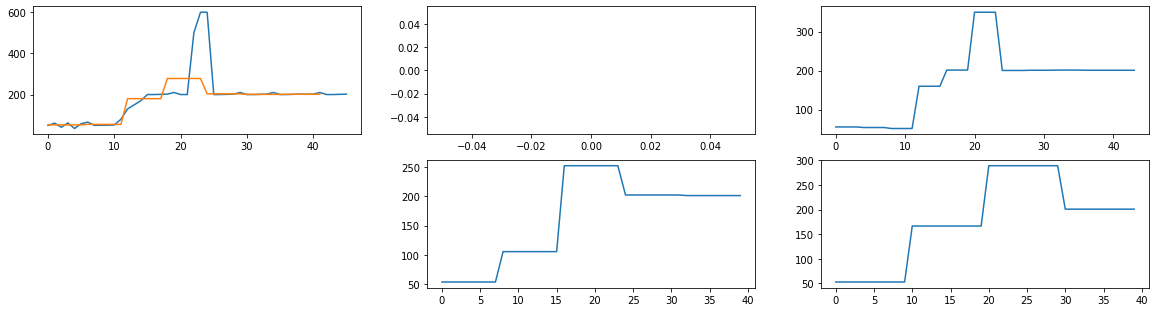

In [47]:
def median(s, n):
    mean = []
        #n:一次采样的次数
    for i in range(int(len(s)/n)):
        select_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        select_s = sorted(select_s)   # 去除最大和最小的
        select_s.remove(select_s[0])
        select_s.remove(select_s[-1])

        if len(select_s) == 0:
            break
        mean_s = np.mean(select_s)
        for j in range(n):       #将取到的值都赋值为平均值，方便画图体现，实际中可以只要一次值
            mean.append(mean_s)
    return mean

plt.figure(figsize = (20,8))

s = s1

plt.subplot(3,3,1)
plt.plot(s)
list_s = median(s,2)
plt.subplot(3,3,2)
plt.plot(list_s)
list_s = median(s,4)
plt.subplot(3,3,3)
plt.plot(list_s)
list_s = median(s,6)
plt.subplot(3,3,1)
plt.plot(list_s)
list_s = median(s,8)
plt.subplot(3,3,5)
plt.plot(list_s)
list_s = median(s,10)
plt.subplot(3,3,6)
plt.plot(list_s)

plt.show()